# Práctica 1 - Self-Organising Maps
## Preparación de entorno
#### Instalar las librerías

In [48]:
# %pip install numpy
# %pip install matplotlib

#### Importar librerías de código

In [49]:
%reset
# from __future__ import division

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches

# Permite que los gráficos sean interactivos en el notebook
%matplotlib inline

## SOM Setup
* **SOM** $\rightarrow$ Red neuronal no supervisada que reduce la dimensionalidad de los datos y los visualiza en un mapa 2D (Mapa autoorganizado).
  * Vector de entrada $\rightarrow$ Se le va presentando al SOM y ajusta sus pesos con estos vectores.
  * Autoorganización $\rightarrow$ Las neuroinas que repsonden de forma siilar a cierta entrada se agrupan.
  * Aprendizaje y ajuste $\rightarrow$ Durante el entrenamiento, la red modifica los donde cada mapa se especializa en un patrón específico.
* **Matriz de pesos** $\rightarrow$ Matriz multidimensionl de neuronas que procesea patrones que vienen de un array de neuronas de entrada. 
  * Se inicializa con valores aleatorios (no a partir del vector de entrada, si no que se van ajustando a lo largo del entrenamiento).
* ***Best Matching Unit (BMU)*** $\rightarrow$ Neurona que tiene el vector de pesos más similar al vector de entrada. 
  * El aprendizaje se basa en la actualización de los pesos de la BMU y de las neuronas vecinas. 
  * Los pesos de la BMU se ajustan/actualizan para acercarse al vector de entrada.
* **Vecindad** $\rightarrow$ Neuronas adyacentes a la BMU (es una región de la matriz de pesos).
  * Las neuronas de la vecindad también se ajustan, pero en menor medida que la BMU.
* ***Learning Rate (LR)*** $\rightarrow$ Factor que determina cuánto se ajustan los pesos de la BMU y de las neuronas vecinas.
  * Se reduce a lo largo del tiempo para que el ajuste sea más preciso.
  * Disminuye a medida que nos alejamos de la BMU.

> *Nota* - El SOM aprende a ordenar la matriz de pesos para que reperesente la estructura inherente a los datos de entrada.

In [50]:
lado_mapa = 50
"""Tamaño del mapa de Kohonen (lado_mapa x lado_mapa)"""

periodo = 5000
"""Número total de iteraciones del entrenamiento"""

learning_rate = 0.15
"""Tasa de aprendizaje inicial (cuanto se modifica el peso en cada iteración)"""

normalizar_datos = True
"""Indica si hay que normalizar los datos o no"""

num_entradas = 3
"""Dimensionalidad de los datos de entrada (3 para RGB)"""

num_datos = 100
"""Cantidad de muestras de colores que usaremos para entrenar el SOM"""

valor_maximo = 255
"""Valor máximo de los datos de entrada (255 para RGB)"""

vecindario = lado_mapa // 2
"""Radio de influenia alrededor de la neurona ganadora"""

# Estructura -> minimo, maximo, (numero de colores por dato, numero de datos))
datos = np.random.randint(0, valor_maximo + 1, (num_entradas, num_datos))
"""Matriz de 100 colores con 3 valores RGB aleatorios"""

if normalizar_datos:
    # Escalamos los datos al rango [0, 1]
    datos = datos / np.max(valor_maximo)

matriz_pesos = np.random.random((lado_mapa, lado_mapa, num_entradas))
"""Matriz de pesos de las neuronas"""

'Matriz de pesos de las neuronas'

#### Funciones para entrenar/clasificar
##### Distancia euclídea

La distancia euclídea se define como la raíz cuadrada de la suma de las diferencias al cuadrado de cada componente de los vectores. Tenemos que calcularlo para vectores RGB, por lo que la fórmula es la siguiente:
$$\text{distancia euclídea} = \sqrt{(R_{entrada} - R_{actual})^2 + (G_{entrada} - G_{actual})^2 + (B_{entrada} - B_{actual})^2}$$

In [51]:
def calcular_bmu(patron_entrada, matriz_pesos, num_entradas) -> tuple:
   """Encuentra la BMU (neurona ganadora) para un patrón de entrada.

   Args:
      patron_entrada: Vector de entrada de color RGB normalizado
      matriz_pesos: Matriz de pesos de las neuronas del SOM
      num_entradas: Dimensionalidad de los datos de entrada (3 para RGB)

   Returns:
      tuple (bmu, bmu_idx):
         - bmu: vector de pesos de la neurona ganadora
         - bmu_idx: coordenadas [x,y] de la neurona ganadora
   """

   distancia_minima = float('inf')
   bmu = np.zeros(num_entradas)
   bmu_idx = np.zeros(2)

   # Recorremos cada neurona para encontrar la BMU
   # Filas -> matriz_pesos.shape[0]
   # Columnas -> matriz_pesos.shape[1]
   for fila in range(matriz_pesos.shape[0]):
      for columna in range(matriz_pesos.shape[1]):
         peso_actual = matriz_pesos[fila, columna]

         # Calculamos la distancia euclídea entre el peso actual y el patrón de entrada
         distancia = np.linalg.norm(patron_entrada - peso_actual)

         if distancia < distancia_minima:
            distancia_minima = distancia
            bmu = peso_actual
            bmu_idx = np.array([fila, columna])

   return bmu, bmu_idx

##### Learning Rate

El learning rate es un valor que se va reduciendo a medida que se va entrenando la red. Controla cuánto se modifican los pesos y determina el temaño del ajuste en los pesos de las neuronas. Se calcula usando una función de decaimiento exponencial:
$$\alpha(t) = \alpha_0 \cdot e^{-\frac{t}{T}}$$

Donde:
* $\alpha_0$: Learning rate inicial.
* $t$: Iteración actual.
* $T$: Número total de iteraciones.
* $\alpha(t)$: Learning rate en la iteración $t$.

¿Porque usamos el decaimiento exponencial?:
1. **Fase inicial:**
   * Learning rate alto
   * Nos permite hacer cambios grandes en los pesos
   * Ayuda a la exploración inicial del espacio de colores
2. **Fase media:**
    * Learning rate decrece moderadamente
    * Ajustes más refinados
    * Mejor organización topológica
3. **Fase final:**
   * Learning rate muy pequeño
   * Ajustes muy finos
   * Estabilización del mapa


In [52]:
def variacion_learning_rate(learning_rate_inicial, iteracion_actual, num_iteraciones) -> float:
   """Calcula el Learning Rate (eta) para  la iteración actual.

   Args:
      learning_rate_inicial: Learning rate inicial
      iteracion_actual: Iteración actual
      num_iteraciones: Número total de iteraciones

   Returns:
      float: Learning rate actualizado para la iteración actual
   """

   return learning_rate_inicial * np.exp(-iteracion_actual / num_iteraciones)

##### Vecindario

El vencindario es una región de influencia alrededor de la neurona ganadora que determina qué otrsa neuronas se actualizarán y en que medida. Es como una zona de impacto y también se calcula usando la función de decaimiento exponencial:
$$\sigma(t) = \sigma_0 \cdot e^{-\frac{t}{T}}$$

Donde:
* $\sigma_0$: Radio inicial del vecindario.
* $t$: Iteración actual.
* $T$: Número total de iteraciones.
* $\sigma(t)$: Radio del venciandario en la iteración $t$.

¿Porque usamos el decaimiento exponencial?:
1. **Fase inicial:**
   * Vecindario grande
   * Afecta a muchas neuronas vecinas
   * Organiza global del mapa de Kohonen
2. **Fase media:**
    * Vecindario se va reduciendo gradualmente
    * Afecta a menos neuronas
    * Refina la organización topológica del mapa de Kohonen
3. **Fase final:**
   * Vecindario muy pequeño
   * Solo afecta a la neurona ganadora y sus vecinas inmediatas
   * Ajustes concretos localizados


In [53]:
def variacion_vecindario(vecindario_inicial, iteracion_actual, num_iteraciones) -> float:
   """Calcula el radio del vecindario para la iteración actual.

   Args:
      vecindario_inicial: Radio inicial del vecindario
      iteracion_actual: Iteración actual
      num_iteraciones: Número total de iteraciones

   Returns:
      float: Vecindario actualizado para la iteración actual
   """

   return vecindario_inicial * np.exp(-iteracion_actual / num_iteraciones)

##### Decay (Amortiguación)

El decay es una función que determina cómo se amortigua el learning rate según la distancia entre una neurona y la BMU (neurona ganadora). Se calcula usando una función gaussiana:

$$h(d,\sigma) = e^{-\frac{d^2}{2\sigma^2}}$$

Donde:
* $d$: Distancia entre la neurona y la BMU
* $\sigma$: Radio actual del vecindario
* $h(d,\sigma)$: Factor de amortiguación

¿Por qué usamos una función gaussiana?:
1. **Centro (BMU)**:
   * Distancia = 0
   * Máxima influencia ($\approx 1$)
   * Mayor ajuste de pesos

2. **Neuronas cercanas**:
   * Distancia pequeña
   * Influencia moderada
   * Ajuste proporcional a la cercanía

3. **Neuronas lejanas**:
   * Distancia grande
   * Influencia mínima ($\approx 0$)
   * Casi no se modifican

In [54]:
def decay(distancia_BMU, vecindario_actual) -> float:
   """Calcula la amortiguación de eta en función de la distancia en el mapa entre una neurona y la BMU.

   Args:
      distancia_BMU: Distancia entre la neurona y la BMU
      vecindario_actual: Radio actual del vecindario

   Returns:
      float: Factor de amortiguación para la iteración (Está entre 0 y 1)
   """
   return np.exp(-distancia_BMU / (2 * (vecindario_actual**2)))

#### Funciones para dibujar la salida de la red

In [55]:
def pintar_mapa(matriz_valores, titulo):
    """Función para pintar una matriz de valores como colores RGB.
    Visualiza el mapa de Kohonen, donde cada neurona se representa como un rectángulo de color RGB.

    Args:
        matriz_valores: Matriz de valores RGB (lado_mapa x lado_mapa x 3)
        titulo: Titulo del mapa
    """

    # Creamos una nueva figura
    fig = plt.figure()

    # Establecemos los ejes
    ax = fig.add_subplot(111, aspect='equal') # aspect='equal' mantiene cuadrados los rectángulos
    ax.set_xlim((0, matriz_pesos.shape[0]+1)) # Limites del eje x
    ax.set_ylim((0, matriz_pesos.shape[1]+1)) # Limites del eje y
    ax.set_title(titulo)

    # Dibujamos los rectángulos por cada neurona (Un cuadrado RGB)
    for fila in range(1, matriz_valores.shape[0] + 1):
        for columna in range(1, matriz_valores.shape[1] + 1):
            ax.add_patch(patches.Rectangle(
                (fila - 0.5, columna - 0.5),                           # Posición (x,y) del rectángulo
                1, 1,                                                  # Ancho y alto del rectángulo
                facecolor = matriz_valores[fila - 1, columna - 1, :],  # Color RGB del rectángulo
                edgecolor = 'none'                                     # Sin borde
            ))

    plt.show()

## SOM Entrenamiento

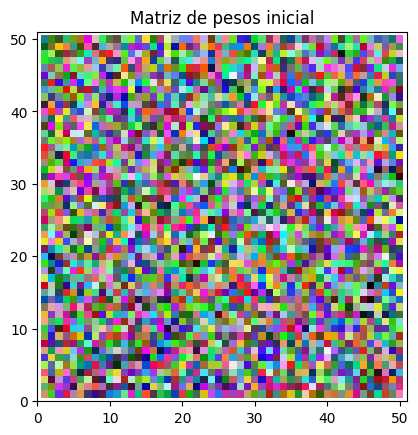

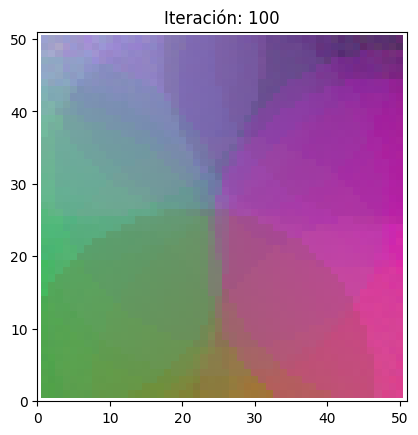

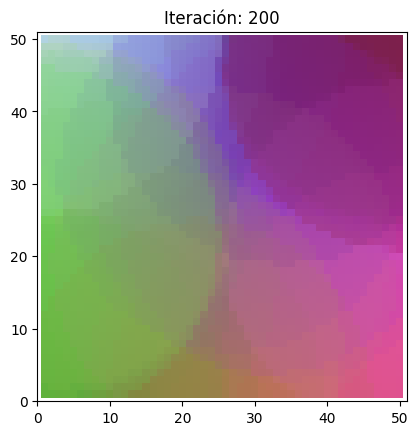

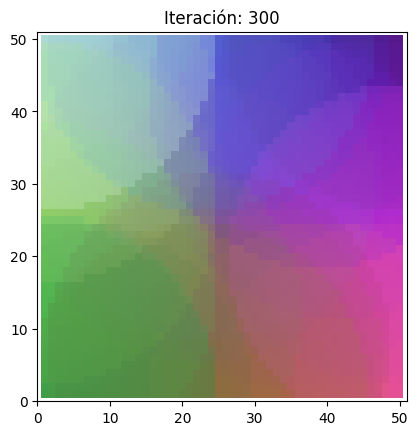

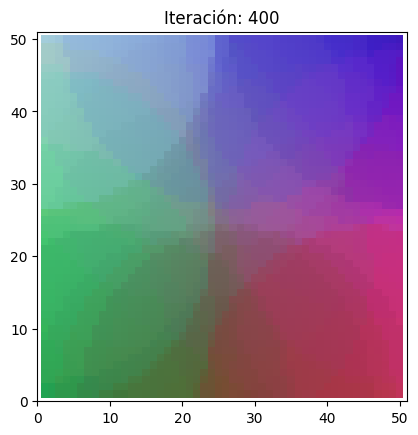

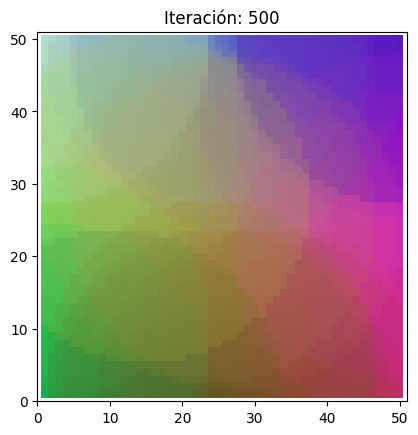

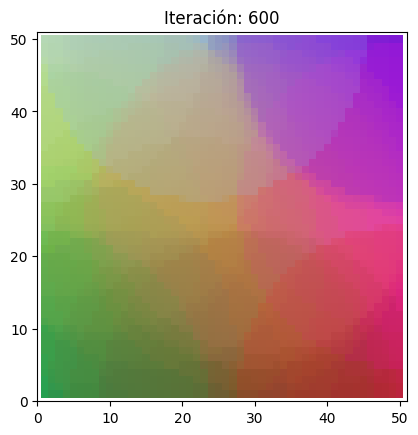

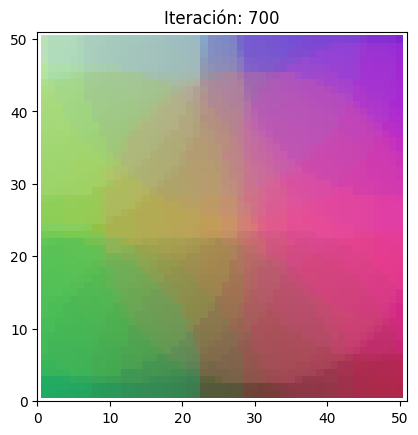

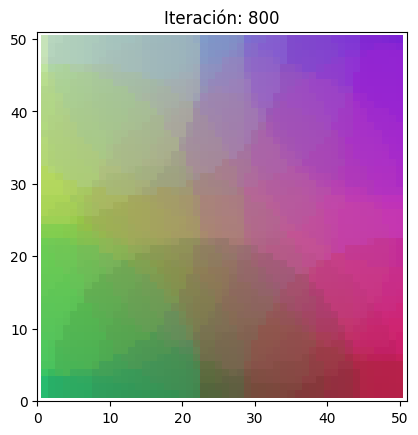

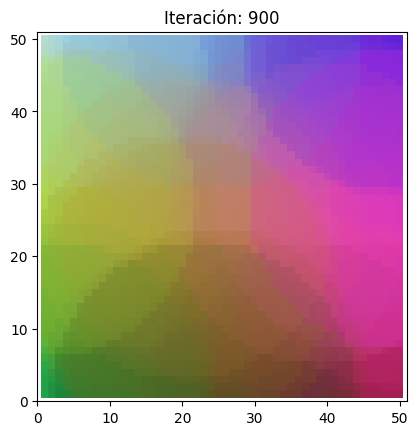

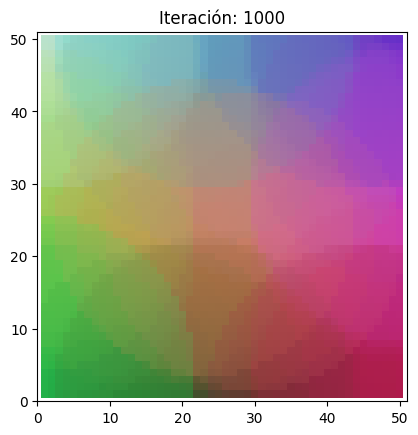

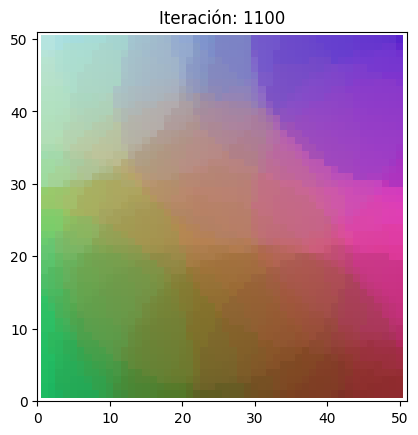

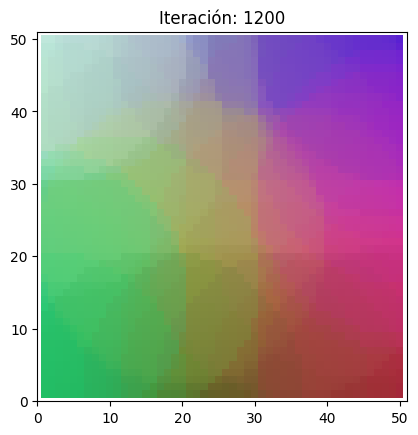

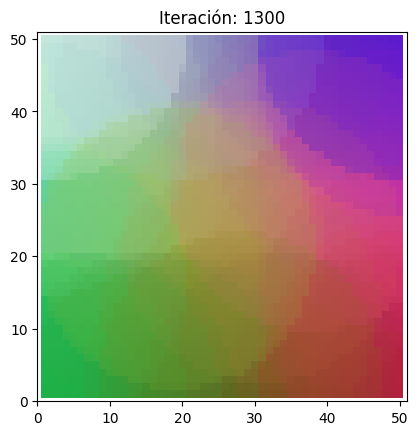

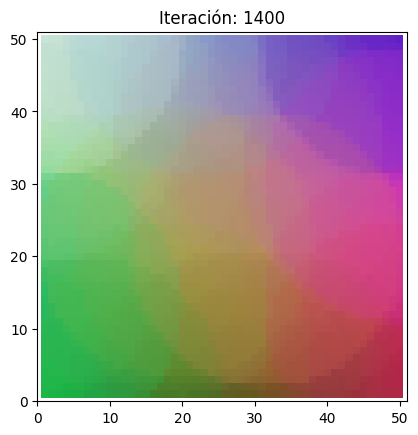

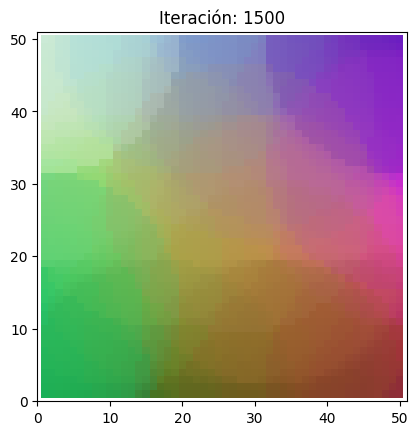

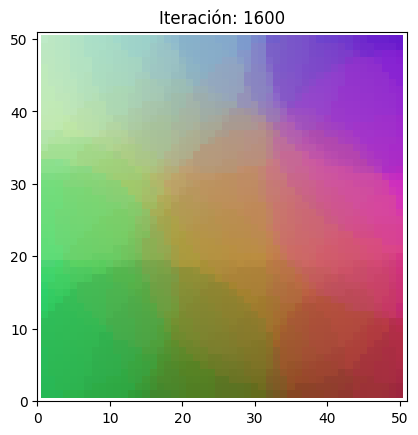

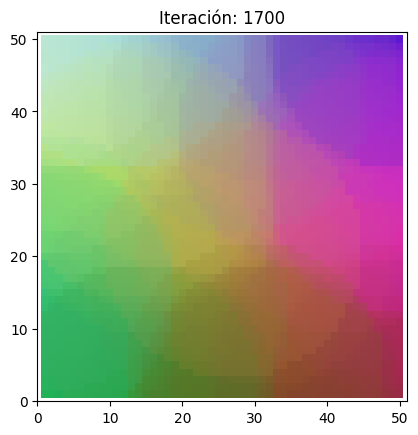

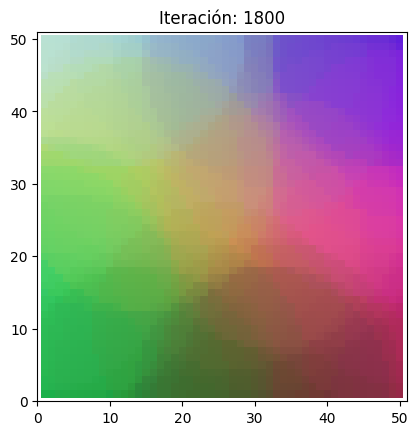

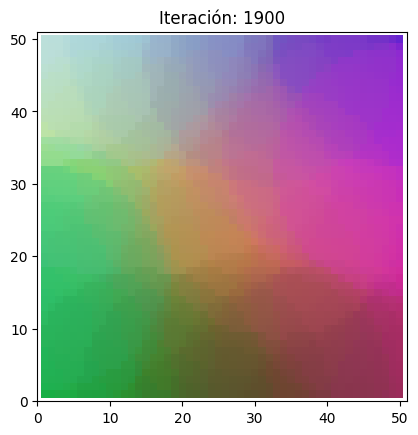

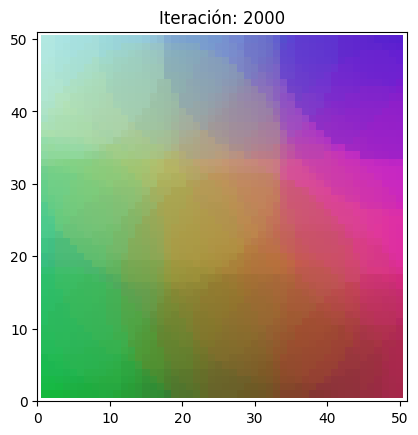

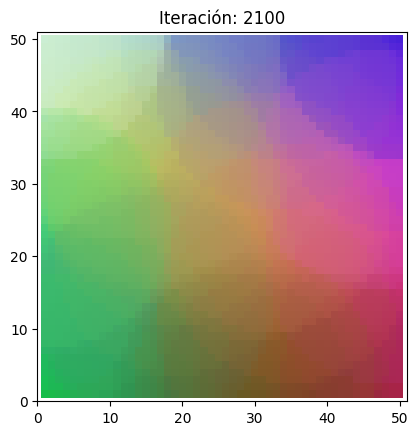

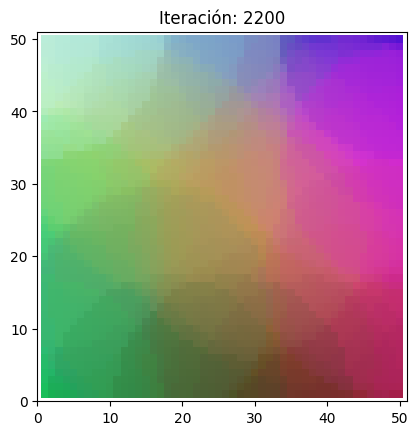

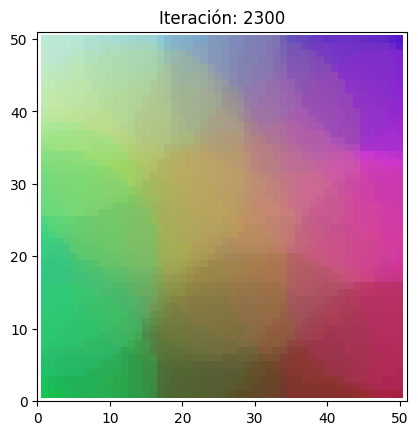

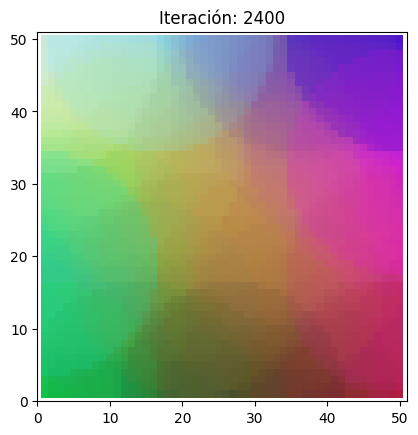

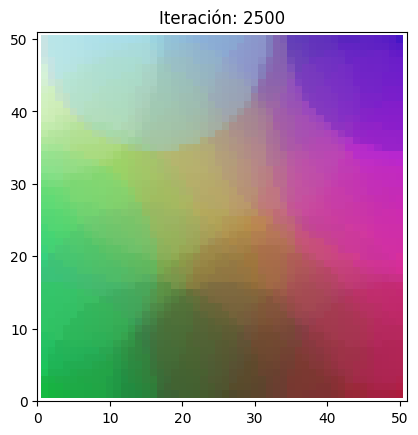

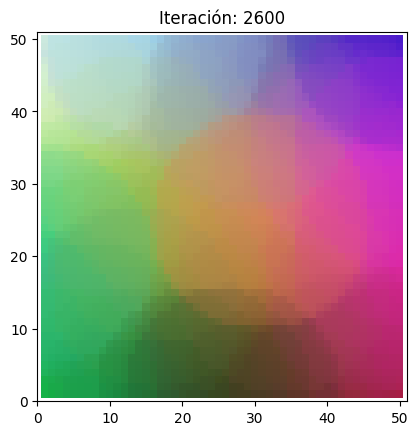

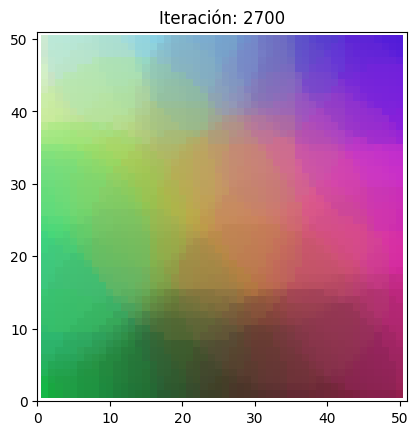

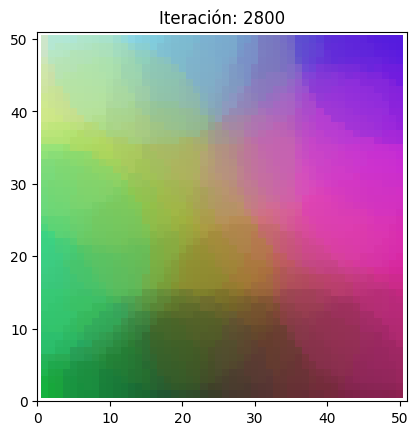

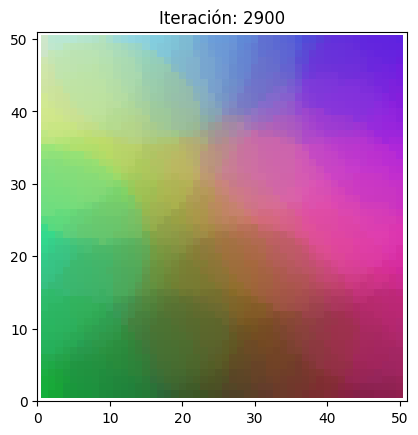

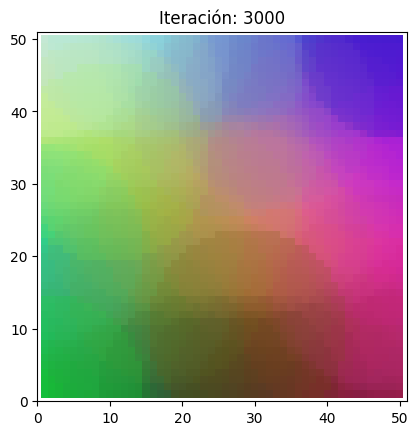

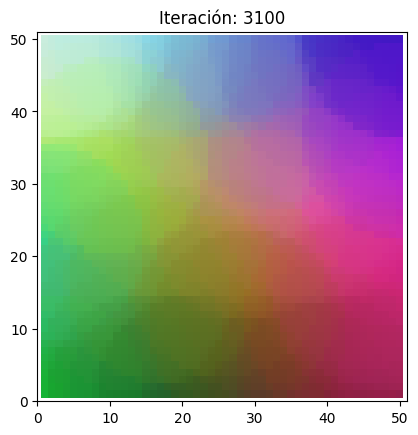

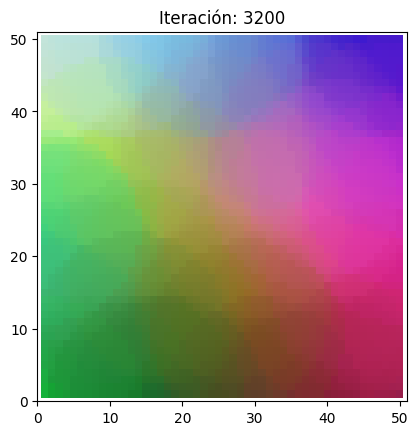

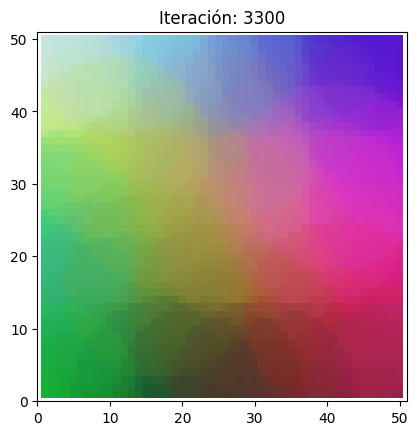

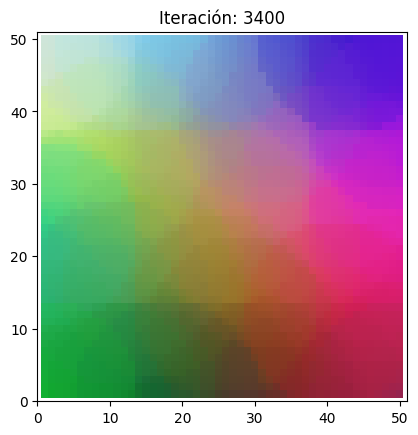

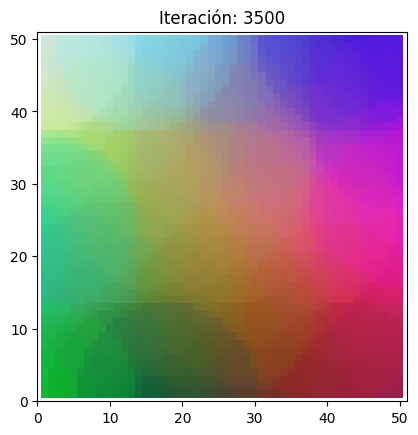

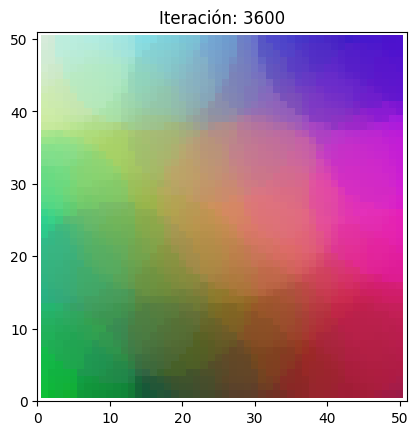

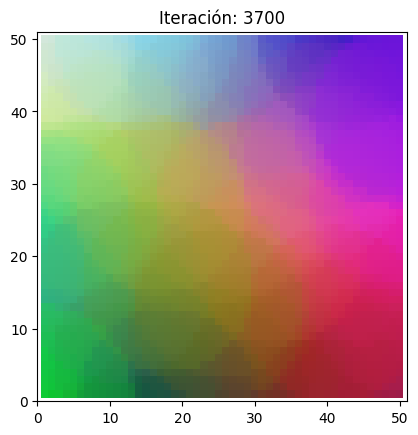

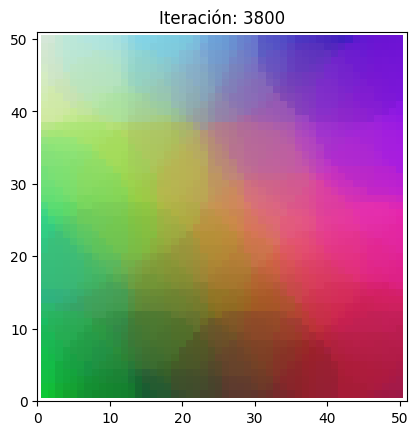

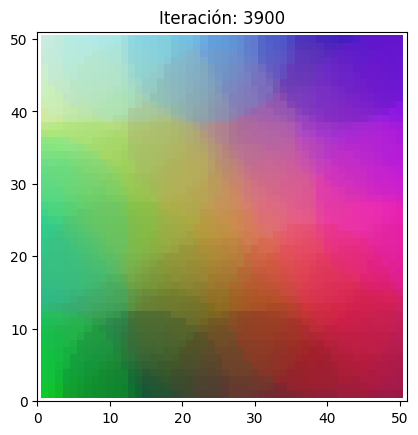

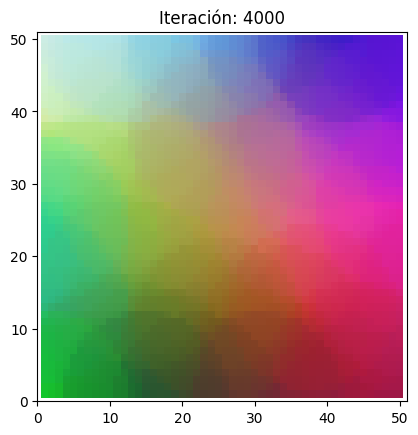

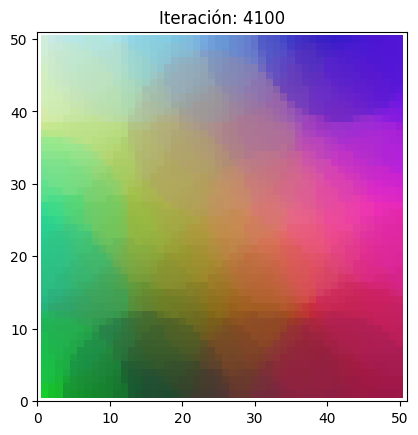

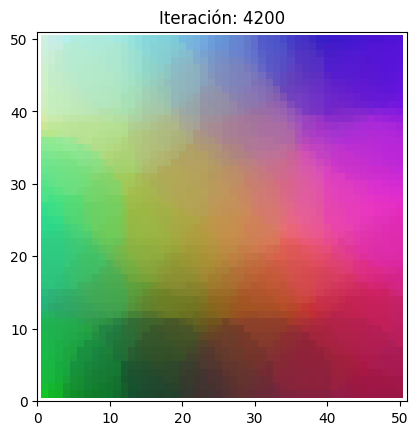

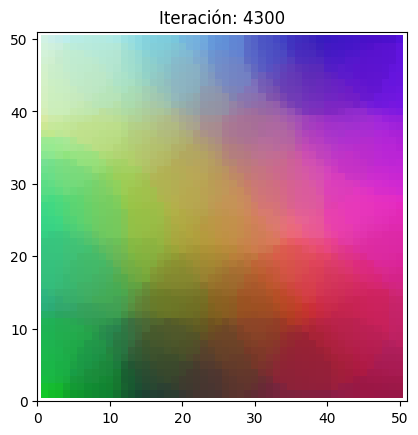

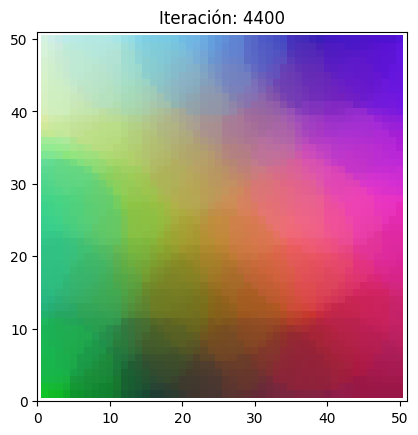

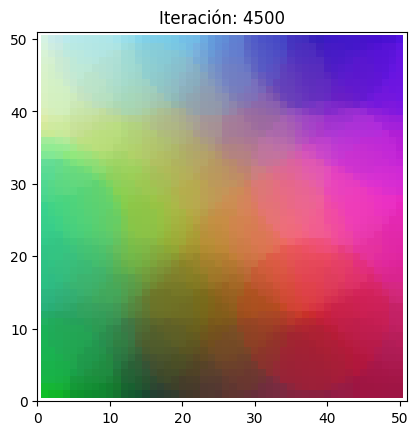

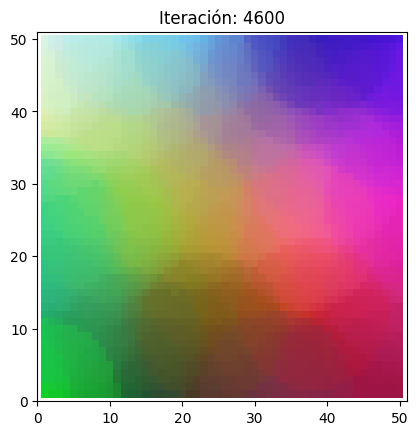

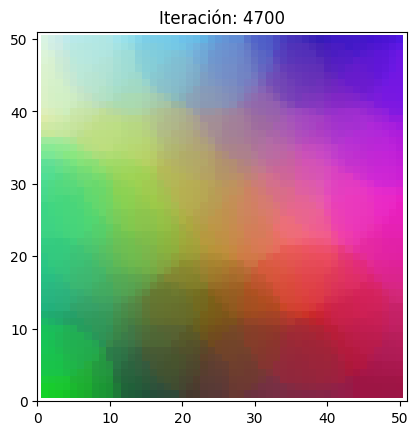

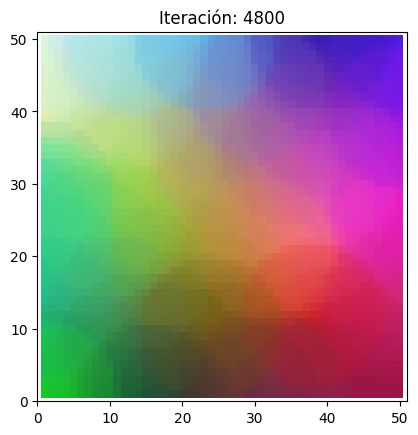

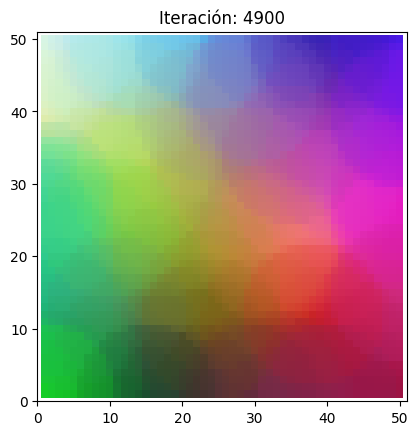

In [56]:
# Pintamos la matriz de pesos inicial
pintar_mapa(matriz_pesos, "Matriz de pesos inicial")

# Entrenamiento del SOM
for epoca in range(periodo):
    # Seleccionamos un patrón de entrada aleatorio
    patron_azar = datos[:, np.random.randint(0, num_datos)]

    # Buscamos la BMU para el patrón de entrada
    bmu, bmu_idx = calcular_bmu(patron_azar, matriz_pesos, num_entradas)

    # Calculamos los parámetros para esta iteración
    lr_actual = variacion_learning_rate(learning_rate, epoca, periodo)
    vec_actual = variacion_vecindario(vecindario, epoca, periodo)

    # Actualizamos el vector de pesos de la BMU y sus vecinos
    for fila in range(matriz_pesos.shape[0]):
        for columna in range(matriz_pesos.shape[1]):
            # Calculamos la distancia a la BMU
            distancia_bmu = np.linalg.norm([fila - bmu_idx[0], columna - bmu_idx[1]])
            if distancia_bmu <= vec_actual:
                # Calculamos la influencia basada en la distancia
                influencia = np.exp(-(distancia_bmu**2) / (2 * vec_actual**2))

                # Actualizamos los pesos usando la fórmula
                matriz_pesos[fila, columna] += lr_actual * influencia * (patron_azar - matriz_pesos[fila, columna])

    if epoca % 100 == 0 and epoca != 0:
        # Pintamos la matriz de pesos
        pintar_mapa(matriz_pesos, f"Iteración: {epoca}")


## SOM Clasificación

In [57]:
# Clasifica los patrones de entrenamiento con la matriz de pesos recién entrenada



## SOM Prueba

In [58]:
# Clasifica nuevos patrones

